In [1]:
import cv2
import dlib
import numpy as np
import os
import joblib
import random
from matplotlib import pyplot as plt
from imutils import face_utils
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from skimage.filters import gabor
from imutils import paths

Load models

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Download required dlib file

Dataset path

In [2]:
dataset_path = "FER2013"  # Change to your dataset folder
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

READ THE DATASET

In [7]:
imagePaths = list(paths.list_images('FER2013'))
emotion_labels = sorted(os.listdir(dataset_path))
print(f"[INFO] Total images found: {emotion_labels}")
emotion_labels
print(f"[INFO] Classes: {emotion_labels}")

[INFO] Total images found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'test', 'train']
[INFO] Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'test', 'train']


SHOW THE SAMPLES OF DATASET

In [9]:
print("\nDataset distribution:")
print(Counter(emotion_labels))


Dataset distribution:
Counter({'angry': 1, 'disgust': 1, 'fear': 1, 'happy': 1, 'neutral': 1, 'sad': 1, 'surprise': 1, 'test': 1, 'train': 1})


[INFO] Showing sample dataset images...


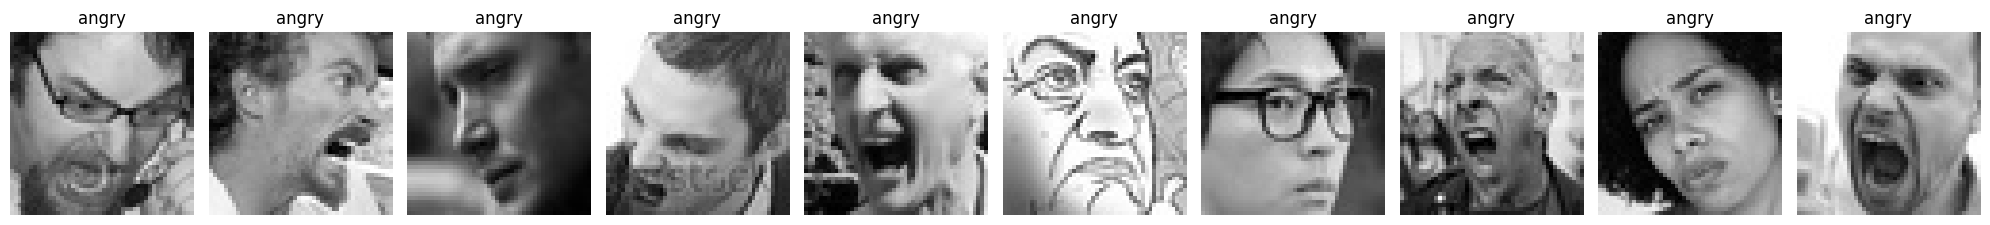

In [10]:
print("[INFO] Showing sample dataset images...")
fig = plt.figure(figsize=(20, 4))

for i in range(10):
    img_path = imagePaths[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = img_path.split(os.path.sep)[-2]

    ax = fig.add_subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

Define Gabor filter bank

In [7]:
def build_gabor_filters():
    filters = []
    ksize = [3, 5, 7]  # filter sizes
    for theta in np.arange(0, np.pi, np.pi / 4):  # 4 orientations
        for k in ksize:
            kern = cv2.getGaborKernel((k, k), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5 * kern.sum()
            filters.append(kern)
    return filters

Apply Gabor filters to image

In [8]:
def process_gabor(img, filters):
    feats = []
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        feats.append(np.mean(fimg))
        feats.append(np.std(fimg))
    return np.array(feats)

Extract Gabor features

In [9]:
filters = build_gabor_filters()
features = []
labels = []

for path in imagePaths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (48, 48))
    feat = process_gabor(img, filters)
    label = path.split(os.path.sep)[-2]
    features.append(feat)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

print(f"[INFO] Extracted features shape: {features.shape}")

[INFO] Extracted features shape: (43065, 24)


Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

Train SVM classifier

In [11]:
svm_clf = SVC(kernel='rbf', gamma='scale', C=10)
svm_clf.fit(X_train, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Evaluate

In [12]:
# EVALUATE ON TRAINING SET
print("========== TRAINING SET PERFORMANCE ==========")
y_train_pred = svm_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n[TRAIN] Classification Report:\n", classification_report(y_train, y_train_pred, zero_division=0))
print("[TRAIN] Accuracy: {:.2f}%".format(train_accuracy * 100))
print("[TRAIN] Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# EVALUATE ON TEST SET
print("\n========== TESTING SET PERFORMANCE ==========")
y_test_pred = svm_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n[TEST] Classification Report:\n", classification_report(y_test, y_test_pred, zero_division=0))
print("[TEST] Accuracy: {:.2f}%".format(test_accuracy * 100))
print("[TEST] Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


========== TRAINING SET PERFORMANCE ==========

[TRAIN] Classification Report:
               precision    recall  f1-score   support

       angry       0.67      0.00      0.00      4168
     disgust       0.00      0.00      0.00       451
        fear       0.25      0.00      0.00      4277
       happy       0.26      0.93      0.40      7550
     neutral       0.34      0.04      0.08      5193
         sad       0.31      0.07      0.11      5103
    surprise       0.31      0.10      0.15      3403

    accuracy                           0.26     30145
   macro avg       0.30      0.16      0.11     30145
weighted avg       0.34      0.26      0.15     30145

[TRAIN] Accuracy: 26.26%
[TRAIN] Confusion Matrix:
 [[   6    0    1 3804   90  176   91]
 [   0    0    0  419    5    6   21]
 [   0    0    1 3910   79   99  188]
 [   0    0    0 7011  119  189  231]
 [   1    0    1 4603  233  245  110]
 [   1    0    0 4553  137  339   73]
 [   1    0    1 2999   30   47  325]]

===

Cross-validation

3-FOLDS

In [13]:
print("\n==============================")
print("3-Fold Cross Validation Results")
print("==============================")
cv3 = KFold(n_splits=3, random_state=1, shuffle=True)
scores3 = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv3, n_jobs=-1)
print(f"SVM MEAN Accuracy: {np.mean(scores3)*100:.2f}%")
print(f"Standard Deviation: {np.std(scores3)*100:.2f}%")


3-Fold Cross Validation Results
SVM MEAN Accuracy: 25.96%
Standard Deviation: 0.18%


5-FOLDS

In [14]:
print("\n==============================")
print("5-Fold Cross Validation Results")
print("==============================")
cv5 = KFold(n_splits=5, random_state=1, shuffle=True)
scores5 = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv5, n_jobs=-1)
print(f"SVM MEAN Accuracy: {np.mean(scores5)*100:.2f}%")
print(f"Standard Deviation: {np.std(scores5)*100:.2f}%")


5-Fold Cross Validation Results
SVM MEAN Accuracy: 25.99%
Standard Deviation: 0.38%


10-FOLDS

In [15]:
print("\n==============================")
print("10-Fold Cross Validation Results")
print("==============================")
cv10 = KFold(n_splits=10, random_state=1, shuffle=True)
scores10 = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv10, n_jobs=-1)
print(f"SVM MEAN Accuracy: {np.mean(scores10)*100:.2f}%")
print(f"Standard Deviation: {np.std(scores10)*100:.2f}%")


10-Fold Cross Validation Results
SVM MEAN Accuracy: 26.03%
Standard Deviation: 0.54%


SAVE MODEL

In [18]:
joblib.dump(svm_clf, 'SVM-Gabor_model_FER2013.pkl')
np.save('Gabor_emotion_labels.npy', emotion_labels)
print("[INFO] Model saved successfully!")

[INFO] Model saved successfully!
